# CORAL RESTORATION NOTEBOOK

## Load packages

In [1]:
import numpy as np
import seaborn as sns
sns.set(style='ticks', palette='Paired')
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import time
import random
from __future__ import division
from scipy.linalg import circulant
import networkx as nx

%matplotlib inline

# FUNCTIONS

## Growth rate function: growth_fun()

#### Function: 
Growth rate function (Equation (3) from supplemental material to Norberg et al. 2012). <br> 

#### Description: 
Calculate growth rate as a function of species trait (optimum temperature) and local environmental condition (reef temperature).

#### Parameters:
*r_max*:    Maximum growth rate for species <br> 
*T*:        Current temperature of reef <br> 
*z*:        Current optimum temperature for species <br> 
*w*:        Temperature tolerance <br> 
*species_type*: Species type ID that determines type of growth <br>

In [4]:
def growth_fun(r_max,T,z,w,species_type):
    if z.shape[0] > 1: # If there is more than one reef
        T = np.repeat(T,z.shape[1]).reshape(z.shape[0],z.shape[1])
    else: # If there is a single reef
        T = np.array([np.repeat(T,z.shape[1])])
        
    r = np.zeros((z.shape[0],z.shape[1])) #Preallocate growth vector
    coral_col = np.where(species_type == 1)[1]
    algae_col = np.where(species_type == 2)[1]
    r[:,coral_col] =( (r_max[:,coral_col]/np.sqrt(2.*np.pi*pow(w[:,coral_col],2.)))
                    *np.exp((-pow((T[:,coral_col]-z[:,coral_col]),2.))/(2*pow(w[:,coral_col],2.))) )
    r[:,algae_col] = 0.49 * r_max[:,algae_col]

    return r

## Mortality function: mortality_fun()

Mortality rate function proposed as an alternative to constant mortality rate from Norberg et al. (2012) <br>
Determines mortality rate as a function of species trait (optimum temperature) and local environmental condition (reef
temperature).

Note: MPA status only affects algal mortality rate

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*:  Protected area status of the reef <br>
*alg_mort*: algal mortality rate in non-mpa reefs

In [5]:
def mortality_fun(r_max,T,z,w,species_type,mpa_status,alg_mort):
    
    m = np.zeros((z.shape[0],z.shape[1])) # Preallocate mortality vector
    algae_col = np.array([np.where(species_type == 2)[1]]) # Find algae columns
    
    if z.shape[0] > 1: # If there is more than one reef
        T = np.repeat(T,z.shape[1]).reshape(z.shape[0],z.shape[1]) # Reshape T array to correspond with z matrix
        
        m[z<T] = 1 - np.exp(-pow((T-z),2)/pow(w,2))[z<T]
        m[z>=T] = 0
        
        # Indices of mpa reefs (corresponds to rows in N_all)
        is_mpa = np.array([np.where(mpa_status == 1)[1]]) 
        # Indices of non-mpa reefs (corresponds to rows in N_all)
        not_mpa = np.array([np.where(mpa_status != 1)[1]])
        
        # Create arrays of indices that correspond to is_mpa & algae_col and not_mpa & algae_col
        is_mpa_rows = np.array([is_mpa.repeat(algae_col.shape[1])]) 
        not_mpa_rows = np.array([not_mpa.repeat(algae_col.shape[1])])
        algae_col_is_mpa = np.tile(algae_col,is_mpa.shape[1])
        algae_col_not_mpa = np.tile(algae_col,not_mpa.shape[1])

        # Macroalgae calculations for multiple reefs
        m[is_mpa_rows,algae_col_is_mpa] = 0.3
        m[not_mpa_rows,algae_col_not_mpa] = alg_mort[not_mpa_rows]
        
    else: # If there is a single reef
        T = np.array([np.repeat(T,z.shape[1])])
    
        #Coral calculations
        m[z<T] = 1 - np.exp(-pow((T-z),2)/pow(w,2))[z<T]
        m[z>=T] = 0
        
        # Macroalgae calculations for a single reef
        if mpa_status == 1:
             m[0,algae_col] = 0.3
        else:
            m[0,algae_col] = alg_mort

    # Apply a correction such that the minimum amount of mortality experienced is 0.03        
    m[m<0.03] = 0.03
    
    return m

## Fitness function: fitness_fun

Fitness function (Equation (2) from supplemental material to Norberg et al. 2012). Determines fitness as a 
function of local growth rate, mortality rate, and species interactions (competition for space).

#### Calls:
growth_fun( )<br>
mortality_fun( )

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Matrix of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: algal mortality rate in non-mpa reefs

#### Returns:
*g*: A matrix containing the fitness of all species at all reefs, or a single vector of species fitness if there is only one reef

#### Notes: 
The functions growth_fun( ) and mortality_fun( ) already adjust the temperature vector so there is no need to do that in this function. 

In [6]:
def fitness_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort):
    r = growth_fun(r_max,T,z,w,species_type)
    
    # If mortality varies with temperature
    if mortality_model == "temp_vary":
        m = mortality_fun(r_max,T,z,w,species_type,mpa_status,alg_mort)    
    # If mortality is constant
    else: 
        m = m_const
    
    #If there is more than one reef
    if N_all.shape[0] > 1:
        sum_interactions = np.array([np.sum(N_all[index,:] * alphas, axis=1) for index in range(N_all.shape[0])])
    else:
        sum_interactions = np.sum(alphas * N_all, axis=1)

    g = r * (1-sum_interactions) - m
    
    return g

## Function to calculate dg/dz: dGdZ_fun()

Function to calculate the partial derivative of growth rate across changes in trait space. This function is used in the directional selection component of equation (1b) in the Norberg et al. 2012 supplemental material. 

#### Calls:
fitness_fun()

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Vector of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: algal mortality rate in non-mpa reefs

In [7]:
def dGdZ_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort):
    h = 1e-5
    dGdZ = np.zeros(z.shape)
    
    #If there is more than one reef
    if N_all.shape[0] > 1:
        # For each reef
        for i in np.arange(z.shape[0]): 
            # For each species
            for j in np.arange(z.shape[1]):
                h_matrix = np.zeros(z.shape)
                h_matrix[i,j] = h
                # Take the symmetric difference quotient at point z[i,j]
                term1 = fitness_fun(r_max,T,z+h_matrix,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
                term2 = fitness_fun(r_max,T,z-h_matrix,w,alphas,species_type,mpa_status,
                                         N_all,m_const,mortality_model,alg_mort)
                delta = (term1-term2)/(2*h)
                dGdZ[i,j] = delta[i,j]
    else:
        for j in np.arange(z.shape[1]):
            h_array = np.zeros(z.shape)
            h_array[0,j] = h
            # Take the symmetric difference quotient at point z[i,j]
            term1 = fitness_fun(r_max,T,z+h_array,w,alphas,species_type,mpa_status,
                                 N_all,m_const,mortality_model,alg_mort)
            term2 = fitness_fun(r_max,T,z-h_array,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
            delta = (term1-term2)/(2*h)
            dGdZ[0,j] = delta[0,j]
            
    return dGdZ

## Function to calculate d2g/dz2: dGdZ2_fun()

Function to calculate the second partial derivative of growth rate across changes in trait space. This function is used in the genetic laod component of equation (1a) in the Norberg et al. 2012 supplemental material. 

Calls: fitness_fun()

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Matrix of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: algal mortality rate in non-mpa reefs


In [8]:
def dGdZ2_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort):
    h = 1e-5
    dGdZ2 = np.zeros(z.shape)
    
    #If there is more than one reef
    if N_all.shape[0] > 1:
        # For each reef
        for i in np.arange(z.shape[0]): 
            # For each species
            for j in np.arange(z.shape[1]):
                h_matrix = np.zeros(z.shape)
                h_matrix[i,j] = h
                # Take the symmetric difference quotient at point z[i,j]
                term1 = fitness_fun(r_max,T,z+h_matrix,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
                term2 = fitness_fun(r_max,T,z-h_matrix,w,alphas,species_type,mpa_status,
                                         N_all,m_const,mortality_model,alg_mort)
                term3 = fitness_fun(r_max,T,z,w,alphas,species_type,mpa_status,
                                         N_all,m_const,mortality_model,alg_mort)
                delta = (term1+term2-2*term3)/pow(h,2)
                dGdZ2[i,j] = delta[i,j]
                
    else:
        for j in np.arange(z.shape[1]):
            h_array = np.zeros(z.shape)
            h_array[0,j] = h
            # Take the symmetric difference quotient at point z[i,j]
            term1 = fitness_fun(r_max,T,z+h_array,w,alphas,species_type,mpa_status,
                                 N_all,m_const,mortality_model,alg_mort)
            term2 = fitness_fun(r_max,T,z-h_array,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
            term3 = fitness_fun(r_max,T,z,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
            delta = (term1+term2-2*term3)/pow(h,2)
            dGdZ2[0,j] = delta[0,j]
            
    return dGdZ2

## Function to calculate dN/dt: dNdt_fun()

Function to calculate the derivative of percent cover across time. Based on equation (1a) in the Norberg et al. 2012 supplemental material. 

#### Calls: 
fitness_fun()

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Matrix of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: Algal mortality rate in non-mpa reefs <br>
*V*: Genetic variation <br>
*D*: Dispersal matrix (same for all species) <br>
*beta*: Vector of combined dipsersal and effective fecundity rate

In [9]:
def dNdt_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort,V,D,beta):    
    
    if N_all.shape[0] > 1:
        V = np.tile(V, N_all.shape[0]).reshape(N_all.shape[0],N_all.shape[1])
    
    g = fitness_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort)
    dGdZ2 = dGdZ2_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort)      
    popdy = np.multiply(N_all,g)
    genload = 0.5 * V * dGdZ2 * N_all
    
    dispersal = beta * np.dot(D,N_all)
    free_space = 1 - N_all.sum(axis=1)
    larval_input = np.array([dispersal[index,:] * x for index, x in enumerate(free_space)])
    
    # Algae don't experience recruitment from other reefs
    algae_ID = np.where(species_type==2)[1] #find algae columns
    larval_input[:,algae_ID] = 0
    
    dNdt = popdy + genload + larval_input
    
    #! Prevent NaN or population values below 1e-6 in output
    if np.isnan(dNdt).any():
        ID = np.where(np.isnan(dNdt))
        dNdt[ID] = 1e-6
    if (dNdt+N_all < 1e-6).any():
        ID = np.where(dNdt+N_all < 1e-6)
        dNdt[ID] = 1e-6

    return dNdt

## Function to calculate q: q_fun()

Function to prevent directional selection of virtually extinct populations and enhance numerical stability. Described in supplemental material of Norberg et al (2012).

#### Parameters:
*N_all*: Matrix of abundance for all species <br>
*N_min*: Minimum value for percent cover at any given location

In [10]:
def q_fun(N_all, N_min=1e-6):
    q = np.maximum(0, 1- N_min/(np.maximum(N_min,2*N_all)))
    return q

## Function to calculate dZ/dt: dZdt_fun()

Function to calculate the derivative of average trait value across time. Based on equation (1b) in the Norberg et al. 2012 supplemental material. 

#### Calls: 
fitness_fun() <br>
dGdZ_fun()

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Matrix of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: Algal mortality rate in non-mpa reefs <br>
*V*: Genetic variation <br>
*D*: Dispersal matrix (same for all species) <br>
*beta*: Vector of combined dipsersal and effective fecundity rate <br>

In [11]:
def dZdt_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort,V,D,beta):
        
    if N_all.shape[0] > 1:
        V = np.tile(V, N_all.shape[0]).reshape(N_all.shape[0],N_all.shape[1])
    
    q = q_fun(N_all)
    dGdZ = dGdZ_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort)
    directional_selection = q * V * dGdZ
    gene_flow_term1 = (np.dot(D, N_all * z) / np.dot(D, N_all)) - z
    gene_flow_term2 = (beta * np.dot(D, N_all)) / (beta * np.dot(D, N_all) + N_all)
    free_space = 1 - N_all.sum(axis=1)
    gene_flow = np.array([(gene_flow_term1*gene_flow_term2)[index,:] * x for index, x in enumerate(free_space)])
    
    algae_ID = np.where(species_type==2)[1] #find algae columns
    gene_flow[:,algae_ID] = 0
    
    dZdt = directional_selection + gene_flow
    
    return dZdt

## Function to generate initial temperatures across the reef: generate_temps()

Function to generate temperatures across the reef. Temperatures can take on several patterns, including uniform, linear increase, or randomized

#### Parameters:

*size*: Number of patches in the network <br>
*mid*: Mean of the temperature range on reef <br>
*range*: Range of temperatures across reef <br>
*temp_scenario*: Temperature scenario. **Uniform** has same (mid value) temperature at all locations. 
**Linear** has a linearly increasing temperature centered on mid value. 
**Random** draws a random temperature for each patch from a normal distribution with mean equal to mid value, and sd equal to half of range value.

In [12]:
def generate_temps_fun(size,mid=25,temp_range=2.5,temp_scenario='linear'):
    if temp_scenario == 'uniform':
        temps = np.repeat(mid,size)
    if temp_scenario == 'linear':
        temps = np.linspace(mid-temp_range, mid+temp_range, size)
    elif temp_scenario == 'random':
        a = np.linspace(mid-temp_range, mid+temp_range, size)
        temps = np.random.choice(a, size, replace=False, p=None)
    return temps

## Function to generate a gradient of temperatures based on a cosine function: generate_temps_cos_fun()

Function to generate temperatures across the reef. Temperatures can take on several patterns, including uniform, linear increase, or randomized

#### Parameters:

*size*: Number of patches in the network <br>
*min_SST*: lowest temperature in network <br>
*max_SST*: highest temperature in network <br>
*mid*: Mean of the temperature range on reef <br>

In [13]:
def generate_temps_cos_fun(size,min_SST=20,max_SST=30):
    range_SST = max_SST - min_SST
    mid = range_SST/2
    mid_SST = (max_SST + min_SST)/2
    x_vals = np.linspace(0,2,size)
    cos_vals = mid * np.cos(np.pi*x_vals) + mid_SST
    return cos_vals

## Function to generate initial traits across the reef: generate_traits_fun()

Function to generate traits across the reef. Traits can take on several patterns including uniform, linear increase or randomized. Traits represent the optimum temperature for species i at each location.

#### Parameters:
*nsp*: Number of species in the model <br>
*size*: Number of patches in the network <br>
*mid*: Mean of the temperature range on reef <br>
*range*: Range of temperatures across reef <br>
*temps*: Temperatures at each reef location <br>
*trait_scenario*: Trait scenario. **u_constant** has unique traits for each species, which are constant across the network. **perfect_adapt** has perfectly adapted organisms, whose traits are equal to the temperature on the reef patch. **same_constant** produces the same trait for all species at all patches.

In [14]:
def generate_traits_fun(nsp,size,temps,mid=25,temp_range=2.5,trait_scenario='perfect_adapt'):
    if trait_scenario == 'u_constant':
        a = np.linspace(mid-(temp_range/4), mid+(temp_range/4), nsp+2)[1:-nsp+2]
        b = np.repeat(a,size)
        traits = np.reshape(b,(nsp,
                               size))
    if trait_scenario == 'same_constant':
        traits = np.full((nsp,size),mid)
    elif trait_scenario == 'perfect_adapt':
        a = np.tile(temps,nsp)
        traits = np.reshape(a,(nsp,size))
    return traits.T

## Function to generate starting percent covers for all species at each patch: generate_state_fun()

In [15]:
def generate_state_fun(size, nsp, cover=0.01,random=False):
    state = np.full((size,nsp),cover)
    if random:
        state = np.full(nsp*size,np.random.uniform(1e-6,.33,nsp*size)).reshape(size,nsp)
    return state

## Function to set MPA design relative to protection strategy: set_MPA_fun()

In [16]:
def set_MPA_fun(temps,N_all,species_type,size,amount=0.2,strategy='random'):
    mpa = np.zeros(size)
    ID = np.where(species_type==1)[1]
    corals = N_all[:,ID].sum(axis=1) # Get the subset of N_all that corresponds to coral cover per reef
    #The following line applies to the 'portfolio' strategy that I haven't coded here
    ncoral = np.asarray(np.where(species_type==1)).sum() # How many coral species?
    
    if strategy == 'none':
        index = np.asarray([])
    elif strategy=='hot':
        index = (-temps).argsort()[0:np.int(amount*size)]
    elif strategy=='cold':
        index = temps.argsort()[0:np.int(amount*size)]
    elif strategy=='hotcold':
        index = np.r_[0:np.int(amount*size/2),np.int(size-(amount*size/2)):np.int(size)]
    elif strategy=='space':
        index = np.round(np.linspace(0,size-1,np.int(amount*size)))
    elif strategy=='highcoral':
        index = (-corals).argsort()[0:np.int(amount*size)]
    elif strategy=='lowcoral':
        index = corals.argsort()[0:np.int(amount*size)]
    elif strategy=='random':
        index = np.random.choice(np.arange(0,size),np.int(amount*size), replace=False)
    
    mpa[index.astype(int)]=1
    return np.array([mpa])    

## Function to set restoration strategy: set_restore_fun()

Function to assign restoration sites on the network. Restoration site assignment can be assigned to hot reefs, cold reefs, low coral, high coral, random, etc.

#### Parameters:
*temps*: Temperatures at each reef location <br>
*N_all*: Number of species in the model <br>
*species_type*: Species type ID, coral=1, macroalgae=2 <br>
*size*: Number of patches in the network <br>
*amount*: Percentage of reefs on network where restoration is active <br>
*strategy*: Strategy that describes placement of restoration sites. **hot** chooses the hottest reefs. **cold** chooses the coldest reefs. **hotcold** chooses the hottest and coldest reefs. **highcoral** chooses the reefs with high coral cover. **lowcoral** chooses the reefs with low coral cover. **random** chooses sites at random.

In [17]:
def set_restore_fun(temps,N_all,species_type,size,amount=1.0,strategy='random'):
    restore_sites = np.zeros(size)
    ID = np.where(species_type==1)[1]
    corals = N_all[:,ID].sum(axis=1) # Get the subset of N_all that corresponds to coral cover per reef
    #The following line applies to the 'portfolio' strategy that I haven't coded here
    ncoral = np.asarray(np.where(species_type==1)).sum() # How many coral species?
    
    if strategy == 'none':
        index = np.asarray([])
    elif strategy=='hot':
        index = (-temps).argsort()[0:np.int(amount*size)]
    elif strategy=='cold':
        index = temps.argsort()[0:np.int(amount*size)]
    elif strategy=='hotcold':
        index = np.r_[0:np.int(amount*size/2),np.int(size-(amount*size/2)):np.int(size)]
    elif strategy=='space':
        index = np.round(np.linspace(0,size-1,np.int(amount*size)))
    elif strategy=='highcoral':
        index = (-corals).argsort()[0:np.int(amount*size)]
    elif strategy=='lowcoral':
        index = corals.argsort()[0:np.int(amount*size)]
    elif strategy=='random':
        index = np.random.choice(np.arange(0,size),np.int(amount*size), replace=False)
    
    restore_sites[index.astype(int)]=1
    return np.array([restore_sites])    

## Function to calculate partial derivatives of pop growth, trait change and temperature change: coral_trait_stoch_fun()

In [18]:
def coral_trait_stoch_fun0(param,spp_state,trait_state,temps,anomalies,algaemort_full,temp_change="constant"):
   
    nsp = param['nsp']
    size = param['size']
    time_steps = param['time_steps']
    species_type = param['species_type']
    r_max = param['r_max']
    V = param['V']
    D = param['D']
    beta = param['beta']
    m_const = param['m_const']
    w = param['w']
    alphas = param['alphas']
    mpa_status = param['mpa_status']
    mortality_model = param['mortality_model']
    maxtemp = param['maxtemp']
    annual_temp_change = param['annual_temp_change']
    timemod = param['timemod']

    SST_matrix = np.zeros([size,time_steps])
    SST_matrix[:,0] = temps + anomalies[:,0]
    dtemp_array = np.zeros([time_steps])
    
    for i in np.arange(1, time_steps):
        temps =  SST_matrix[:,i-1] + anomalies[:,i-1]
        if temp_change == "sigmoid":
            dtemp1 = annual_temp_change*temps.mean()
            dtemp2 = 1-(temps.mean()/maxtemp)
            dtemp = np.repeat(dtemp1*dtemp2, size)
        elif temp_change == "constant":
            dtemp = np.repeat(0, size)
        else: #if temp_change == linear
            dtemp = np.repeat(annual_temp_change, size)
        SST_matrix[:,i] = SST_matrix[:,i-1] + dtemp
    
    N_ALL = np.zeros((size,nsp,time_steps))
    Z_ALL = np.zeros((size,nsp,time_steps))
    N_ALL[:,:,0] = spp_state
    Z_ALL[:,:,0] = trait_state

    algaemort_sub = algaemort_full[:,timemod:timemod+time_steps]
    tick = 0
    
    # Second-order Runge Kutta solver
    for i in np.arange(0,time_steps-1):
        alg_mort = algaemort_sub[:,i]
        dN1 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                         N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)
        dZ1 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                        N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)

        N_ALL_1 = N_ALL[:,:,tick] + dN1*0.5
        Z_ALL_1 = Z_ALL[:,:,tick]  + dZ1*0.5

        dN2 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                         N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)
        dZ2 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                        N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)

        N_ALL[:,:,tick+1] = N_ALL[:,:,tick] + (dN1 + dN2)/2
        Z_ALL[:,:,tick+1] = Z_ALL[:,:,tick] + (dZ1 + dZ2)/2

        tick += 1
    
    return N_ALL, Z_ALL, SST_matrix

## Function to set the value of the restoration trait: set_trait_fun()

In [19]:
def set_trait_fun(Z_all, V, num_restore, restore_array, trait_strategy='value',value=25, scaling_frac=0.5, percentile=50):
    Z_rest = np.zeros((num_restore,Z_all.shape[1]))
    
    if trait_strategy == 'value':
        Z_rest = Z_rest + value
    elif trait_strategy == 'variance':
        Z_rest = Z_all[restore_array,:] + scaling_frac * np.sqrt(V)
    elif trait_strategy == 'percentile':
        for i in np.arange(0,Z_all.shape[1]):
            Z_rest[i] = np.percentile(Z_all[:-num_restore,i], percentile)

    return Z_rest

## Function to calculate partial derivatives of pop growth, trait change and temperature change with restoration: coral_restore_fun()

In [20]:
def coral_restore_fun(param,spp_state,trait_state,temps,anomalies,algaemort_full,
                      temp_change="constant",trait_restore=30,burnin=True):
   
    nsp = param['nsp']
    size0 = param['size']
    time_steps = param['time_steps']
    species_type = param['species_type']
    r_max = param['r_max']
    V = param['V']
    D0 = param['D0']
    D1 = param['D1']
    beta = param['beta']
    m_const = param['m_const']
    w = param['w']
    alphas = param['alphas']
    mpa_status = param['mpa_status']
    mortality_model = param['mortality_model']
    maxtemp = param['maxtemp']
    annual_temp_change = param['annual_temp_change']
    timemod = param['timemod']
    restoration_years = param['restoration_years']
    source_cover = param['source_cover']

    size = size0 + 1 #to account for restoration reef
    
    SST_matrix = np.zeros([size,time_steps])
    SST_matrix[:,0] = temps + anomalies[:,0]
    
    dtemp_array = np.zeros([time_steps])
    
    for i in np.arange(1, time_steps):
        if temp_change == "sigmoid":
            temps =  SST_matrix[:,i-1] 
            dtemp1 = annual_temp_change*temps.mean()
            dtemp2 = 1-(temps.mean()/maxtemp)
            dtemp = np.repeat(dtemp1*dtemp2, size)
            SST_matrix[:,i] = SST_matrix[:,i-1] + dtemp
            
        if temp_change == "constant":
            dtemp = np.repeat(0, size)
            SST_matrix[:,i] = SST_matrix[:,i-1] + dtemp
            
        if temp_change == "linear":
            dtemp = np.repeat(annual_temp_change, size)
            SST_matrix[:,i] = SST_matrix[:,i-1] + dtemp
        
    SST_matrix =  SST_matrix + anomalies
    
    N_ALL = np.zeros((size,nsp,time_steps))
    Z_ALL = np.zeros((size,nsp,time_steps))
    N_ALL[:,:,0] = spp_state
    Z_ALL[:,:,0] = trait_state

    algaemort_sub = algaemort_full[:,timemod:timemod+time_steps]
    tick = 0
    
    if burnin:
        print "BURNIN"
        D = D0 #No restoration, always use baseline connectivity matrix
        # Second-order Runge Kutta solver
        for i in np.arange(0,time_steps-1):
            alg_mort = algaemort_sub[:,i]
            dN1 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                             N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)
            dZ1 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                            N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)

            N_ALL_1 = N_ALL[:,:,tick] + dN1*0.5
            Z_ALL_1 = Z_ALL[:,:,tick]  + dZ1*0.5

            dN2 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                             N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)
            dZ2 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                            N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)

            N_ALL[:,:,tick+1] = N_ALL[:,:,tick] + (dN1 + dN2)/2
            Z_ALL[:,:,tick+1] = Z_ALL[:,:,tick] + (dZ1 + dZ2)/2

            # Keep restoration reef (last reef) at constant N with 100% of all species:
            N_ALL[-1,:,tick+1] = source_cover
            Z_ALL[-1,:,tick+1] = np.repeat(trait_restore,nsp)
            
            tick += 1
            
    else: #For future/restoration scenarios
        print "RUNTIME"
        # Second-order Runge Kutta solver
        for i in np.arange(0,time_steps-1):
            alg_mort = algaemort_sub[:,i]
            
            if tick in restoration_years:
                D=D1
            else:
                D=D0
            
            dN1 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                             N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)
            dZ1 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                            N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)

            N_ALL_1 = N_ALL[:,:,tick] + dN1*0.5
            Z_ALL_1 = Z_ALL[:,:,tick]  + dZ1*0.5

            dN2 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                             N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)
            dZ2 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                            N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)

            N_ALL[:,:,tick+1] = N_ALL[:,:,tick] + (dN1 + dN2)/2
            Z_ALL[:,:,tick+1] = Z_ALL[:,:,tick] + (dZ1 + dZ2)/2

            # Keep restoration reef (last reef) at constant N with 100% of all species:
            N_ALL[-1,:,tick+1] = source_cover
            Z_ALL[-1,:,tick+1] = np.repeat(trait_restore,nsp)

            tick += 1
    
    return N_ALL, Z_ALL, SST_matrix

In [21]:
def coral_restore_fun2(param,spp_state,trait_state,temps,anomalies,algaemort_full,temp_change="constant",
                       burnin=True):

    nsp = param['nsp']
    size0 = param['size']
    time_steps = param['time_steps']
    species_type = param['species_type']
    r_max = param['r_max']
    V = param['V']
    D0 = param['D0']
    D1 = param['D1']
    beta = param['beta']
    m_const = param['m_const']
    w = param['w']
    alphas = param['alphas']
    mpa_status = param['mpa_status']
    mortality_model = param['mortality_model']
    maxtemp = param['maxtemp']
    annual_temp_change = param['annual_temp_change']
    timemod = param['timemod']
    restoration_years = param['restoration_years']
    source_cover = param['source_cover']
    trait_strategy = param['trait_strategy']
    value = param['value']
    scaling_frac = param['scaling_frac']
    percentile = param['percentile']
    num_restore = param['num_restore']
    restore_array = param['restore_array']
        
    size = size0 + num_restore #to account for restoration reef
    
    SST_matrix = np.zeros([size,time_steps])
    SST_matrix[:,0] = temps + anomalies[:,0]
    dtemp_array = np.zeros([time_steps])
    
    for i in np.arange(1, time_steps):
        if temp_change == "sigmoid":
            temps =  SST_matrix[:,i-1] 
            dtemp1 = annual_temp_change*temps.mean()
            dtemp2 = 1-(temps.mean()/maxtemp)
            dtemp = np.repeat(dtemp1*dtemp2, size)
            SST_matrix[:,i] = SST_matrix[:,i-1] + dtemp
            
        if temp_change == "constant":
            dtemp = np.repeat(0, size)
            SST_matrix[:,i] = SST_matrix[:,i-1] + dtemp
            
        if temp_change == "linear":
            dtemp = np.repeat(annual_temp_change, size)
            SST_matrix[:,i] = SST_matrix[:,i-1] + dtemp
        
    SST_matrix =  SST_matrix + anomalies
    
    N_ALL = np.zeros((size,nsp,time_steps))
    Z_ALL = np.zeros((size,nsp,time_steps))
    N_ALL[:,:,0] = spp_state
    Z_ALL[:,:,0] = trait_state

    algaemort_sub = algaemort_full[:,timemod:timemod+time_steps]
    tick = 0
    
    if burnin:
        print "BURNIN"
        D = D0 #No restoration, always use baseline connectivity matrix
        # Second-order Runge Kutta solver
        for i in np.arange(0,time_steps-1):
            alg_mort = algaemort_sub[:,i]
            dN1 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                             N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)
            dZ1 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                            N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)

            N_ALL_1 = N_ALL[:,:,tick] + dN1*0.5
            Z_ALL_1 = Z_ALL[:,:,tick]  + dZ1*0.5

            dN2 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                             N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)
            dZ2 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                            N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)
 
            N_ALL[:,:,tick+1] = N_ALL[:,:,tick] + (dN1 + dN2)/2
            Z_ALL[:,:,tick+1] = Z_ALL[:,:,tick] + (dZ1 + dZ2)/2
            
            #! CURRENTLY WORKING ON THE FOLLOWING LINES:
            #! Calls the function that sets trait restoration
            trait_restore = set_trait_fun(Z_ALL[:,:,tick+1], V, num_restore, restore_array, trait_strategy, value, scaling_frac, percentile)

            # Keep restoration reef (last reef) at constant N with 100% of all species:
            N_ALL[-num_restore:,:,tick+1] = source_cover
            Z_ALL[-num_restore:,:,tick+1] = trait_restore
            
            tick += 1
            
    else: #For future/restoration scenarios
        print "RUNTIME"
        # Second-order Runge Kutta solver
        for i in np.arange(0,time_steps-1):
            alg_mort = algaemort_sub[:,i]
            
            if tick in restoration_years:
                D=D1
            else:
                D=D0
            
            dN1 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                             N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)
            dZ1 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                            N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)

            N_ALL_1 = N_ALL[:,:,tick] + dN1*0.5
            Z_ALL_1 = Z_ALL[:,:,tick]  + dZ1*0.5

            dN2 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                             N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)
            dZ2 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                            N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)

            N_ALL[:,:,tick+1] = N_ALL[:,:,tick] + (dN1 + dN2)/2
            Z_ALL[:,:,tick+1] = Z_ALL[:,:,tick] + (dZ1 + dZ2)/2
            
            #! CURRENTLY WORKING ON THE FOLLOWING LINES:
            #! Calls the function that sets trait restoration
            trait_restore = set_trait_fun(Z_ALL[:,:,tick+1], V, num_restore, restore_array, trait_strategy, value, scaling_frac, percentile)
            # Keep restoration reef (last reef) at constant N with 100% of all species:
            N_ALL[-num_restore:,:,tick+1] = source_cover
            Z_ALL[-num_restore:,:,tick+1] = trait_restore

            tick += 1
    
    return N_ALL, Z_ALL, SST_matrix

In [22]:
test = np.arange(0,10)
print test
print test[-5:]
print test[:-5]

[0 1 2 3 4 5 6 7 8 9]
[5 6 7 8 9]
[0 1 2 3 4]


# Parameters

In [77]:
nsp = 2 # Number of species in model
size = 20 # Number of reefs in model 
burnin = 1000 # Length of burn-in period
runtime = 500 # Length of environmental change period
mid = 27. # Mean temperature across all reefs at start of simulation
temp_range = 3. # Range of temperatures across reefs at start of simulation
species_type = np.array([[1,2]]) # Species type ID
species = ["C1","M1"] # Species labels
iterations = 50 # Number of stochastic iterations
temp_stoch = 0.2
r_max = np.array([[1.5,1.]])
w = np.array([[1.5,2.]])
beta = np.array([[.1,.1]])
alphas = np.array([[1.,1.2],[1.,1.]]) 
m_const = 0.1 # Value used for constant mortality case
mortality_model = "temp_vary"
alg_mort = 0.15
V = np.array([[0.1,0.1]])
annual_temp_change = 0.011
maxtemp = 32 #for sigmoid temperature increase scenario

# Restoration parameters

In [25]:
trait_strategy = 'value' #Options: 'value', 'variance', 'percentile'
value = 33 #For value strategy (and initial restoration value for other strategies)
scaling_frac = 0.5 #For variance strategy
percentile = 50 #For percentile strategy

## Create Multivariate normal covariance matrix for temperature anomalies

In [26]:
mdim = size 
lindec = np.exp(np.linspace(0,-5,num=mdim)) # Decrease the second value to reduce the range of correlation
ma = np.zeros((mdim,mdim))
ma[:,0] = lindec

for i in np.arange(1,mdim):
    ma[i:,i] = lindec[0:-i]
    
ma_temp = ma + ma.T
np.fill_diagonal(ma_temp,np.diagonal(ma))
ma = ma_temp    

print np.all(np.linalg.eigvals(ma) > 0 & np.all(ma-ma.T==0)) # Check if the matrix is positive definite
sds = np.array([np.repeat(.2*temp_stoch,size)])
b = np.multiply(sds,sds.T)
spatial_temp = b*ma

True


Text(0.5,1,'Temperature anomaly covariance matrix')

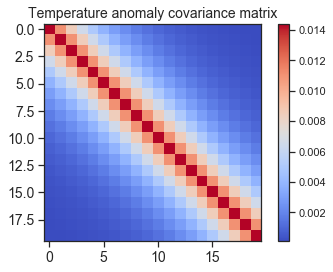

In [27]:
plt.imshow(spatial_temp, cmap='coolwarm')#, vmin=0., vmax=1.)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar()
plt.title("Temperature anomaly covariance matrix", fontsize=14)

## Function that modifies a connectivity matrix to "bias" the diagonal: bias_diagonal()

In [28]:
def bias_diagonal(A, alpha):
    I = np.identity(A.shape[0])
    A_bias = (1-alpha)*A + alpha*I
    return A_bias

## Set of functions to generate random and regular matrices

In [30]:
def _distance_matrix(L):
    Dmax = L//2
 
    D  = range(Dmax+1)
    D += D[-2+(L%2):0:-1]
 
    return circulant(D)/Dmax
    
def _pd(d, p0, beta):
    return beta*p0 + (d <= p0)*(1-beta)
    
def watts_strogatz(L, p0, beta, directed=False, rngseed=1):
    rng = np.random.RandomState(rngseed)
 
    d = _distance_matrix(L)
    p = _pd(d, p0, beta)
 
    if directed:
        A = 1*(rng.random_sample(p.shape) < p)
        np.fill_diagonal(A, 0)
    else:
        upper = np.triu_indices(L, 1)
 
        A          = np.zeros_like(p, dtype=int)
        A[upper]   = 1*(rng.rand(len(upper[0])) < p[upper])
        A.T[upper] = A[upper]
 
    return A

def preserve_self_loops(matrix0, edges):
    # matrix0 needs to have 1's in the diagonal for this to work
    matrix1=matrix0
    for i in np.arange(0,matrix0.shape[0]):
        deg_dist = np.count_nonzero(matrix0[i,:])
        if deg_dist > edges:
            for k in np.arange(0,deg_dist-edges):
                non_zeros = (np.where(matrix0[i,:]>0)[0]).tolist()
                non_zeros.remove(i)
                random_index = non_zeros[np.random.randint(0,len(non_zeros))]
                matrix1[i,random_index] = 0
    return matrix1

def D_norm(D0):
    size = D0.shape[0]
    D1  = np.zeros((size,size)) # Preallocate matrix
    for i in np.arange(size):
        D1[:,i]  = (D0[:,i] / D0[:,i].sum()).T
    return D1

# Function to generate random matrix

In [31]:
def gen_rand_matrix(size, seed, connections=4):    
    # Network size = 20
    #! Note: directed = False produces a symmetric matrix
    random.seed(seed)

    L = size
    K = connections
    p0 = K/(L-1)
    regular = watts_strogatz(beta=0,directed=False,L=L,p0=p0)

    G = nx.Graph()
    G.add_nodes_from(np.arange(0,size))

    for i in np.arange(0,size):
        for j in np.arange(0,size):
            if regular[i,j] == 1:
                G.add_edge(i,j)
            
    reg_G = nx.to_numpy_matrix(G)
    di = np.diag_indices(size)

    random_G = nx.double_edge_swap(nx.from_numpy_matrix(reg_G), nswap=size, max_tries=1000)
    random_G2 = nx.to_numpy_matrix(random_G)

    di = np.diag_indices(size)
    random_G2[di]=1

    edges = connections+1
    random_G2_revised = np.asarray(preserve_self_loops(random_G2,edges=edges))
    
    random_G2_norm = D_norm(random_G2_revised)
    
    return random_G2_norm

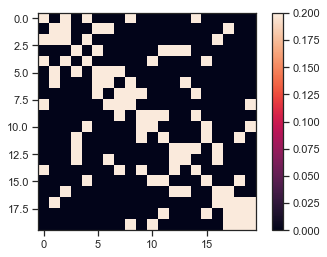

In [32]:
connections=4
seed=np.random.randint(0,1000)
D = gen_rand_matrix(size=size,seed=seed,connections=connections)
plt.imshow(D)
plt.colorbar()

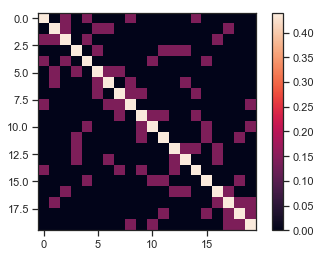

In [33]:
D_rand_bias = bias_diagonal(D, alpha=0.3)
plt.imshow(D_rand_bias)
plt.colorbar()

# Function to generate regular matrix

In [34]:
def gen_reg_matrix(size, connections=4):    
    #! Note: directed = False produces a symmetric matrix
    L = size
    K = connections
    p0 = K/(L-1)
    regular = watts_strogatz(beta=0,directed=False,L=L,p0=p0)
    
    G = nx.Graph()
    G.add_nodes_from(np.arange(0,size))

    for i in np.arange(0,size):
        for j in np.arange(0,size):
            if regular[i,j] == 1:
                G.add_edge(i,j)
            
    reg_G = nx.to_numpy_matrix(G)
    di = np.diag_indices(size)
    reg_G[di]=1
    
    reg_G_norm = D_norm(reg_G)

    return reg_G_norm

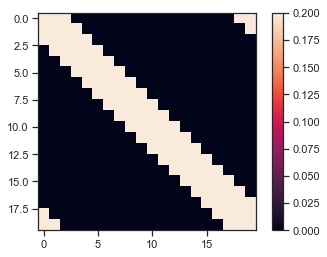

In [35]:
connections=4
D = gen_reg_matrix(size=size, connections=connections)
plt.imshow(D)
plt.colorbar()

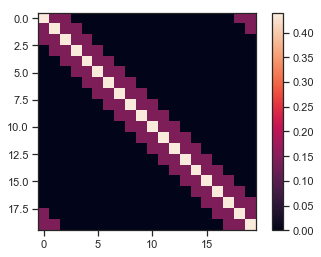

In [36]:
D_reg_bias = bias_diagonal(D, alpha=0.30)
plt.imshow(D_reg_bias)
plt.colorbar()

## Function that generates a matrix that approximates a linear configuration such that each patch can only send larvae to its two adjacent patches: D_linear()

In [37]:
def D_linear(size, p_dispersal):
    D_linear = np.zeros((size,size))
    
    for i in np.arange(0,size):
        D_linear[i,i]= 1-p_dispersal*2
        if i != 0 and i != size-1:
            D_linear[i,i-1] = p_dispersal
            D_linear[i,i+1] = p_dispersal
        if i != 0 and i == size-1:
            D_linear[i,i-1] = p_dispersal
        if i == 0 and i != size-1:
            D_linear[i,i+1] = p_dispersal
            
    return D_linear  

# MAIN ROUTINE

In [38]:
np.random.seed(0)

# Choose the connectivity matrix

In [39]:
SST0 = generate_temps_cos_fun(size,min_SST=20,max_SST=30) 
spp_state = generate_state_fun(size, nsp, cover=0.25,random=False) 


#! Choose the baseline connectivity matrix (source reef does not contribute anything):
connections=4 # Number of patches (NOT including itself) that a patch is connected to

#Set the seed to a constant if you want to generate the same random matrix
#seed = np.random.randint(0,1000) 
seed=11
#! REGULAR MATRIX
D0 = gen_reg_matrix(size=size, connections=connections)
#! Choose sites to restore
amount = 0.2
strategy = 'hot'
restore_status = set_restore_fun(SST0,spp_state,species_type,size,amount,strategy)
num_restore = np.count_nonzero(restore_status)

# Matrix with restoration site row and column
D1 = np.zeros((D0.shape[0]+num_restore,D0.shape[1]+num_restore))
D1[:-num_restore,:-num_restore] = D0
D_no_restore = np.zeros(D1.shape)
D_no_restore[:,:] = D1

#Set the 'no restore' matrix such that extra source reefs are self_recruiting
for i in np.arange(size,size+num_restore):
    D_no_restore[i,i] = 1.0

D_restore = np.zeros(D_no_restore.shape)
D_restore[:,:] = D_no_restore

restore_array = np.where(restore_status == 1)[1]

i=size
for site in restore_array:
    D_restore[site,i] = 1.0
    i += 1

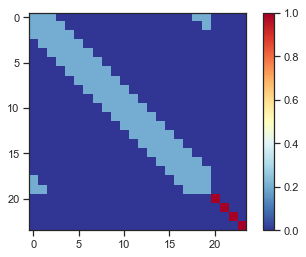

In [40]:
plt.imshow(D_no_restore, cmap='RdYlBu_r')
plt.colorbar()

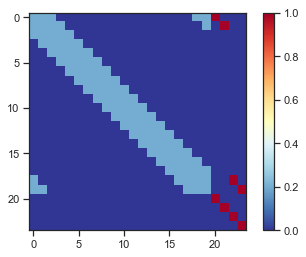

In [41]:
plt.imshow(D_restore, cmap='RdYlBu_r')
plt.colorbar()

In [94]:
anomalies_burn = np.tile(np.random.normal(0,temp_stoch,burnin),size).reshape((size,burnin)) 
anomalies_burn_restore = np.ones((anomalies_burn.shape[0]+num_restore,anomalies_burn.shape[1]))
anomalies_burn_restore[:-num_restore,:] = anomalies_burn
anomalies_burn_restore[-num_restore:,:] = anomalies_burn[-1,:]
#shape: number of reefs x time steps 

anomalies_run = np.tile(np.random.normal(0,temp_stoch,runtime),size).reshape((size,runtime)) 
anomalies_run_restore = np.ones((anomalies_run.shape[0]+num_restore,anomalies_run.shape[1]))
anomalies_run_restore[:-num_restore,:] = anomalies_run
anomalies_run_restore[-num_restore:,:] = anomalies_run[-1,:]
#shape: number of reefs x time steps 

algaemort = np.random.uniform(alg_mort,alg_mort,(runtime+burnin)*size).reshape((size,runtime+burnin))
algaemort_restore = np.ones((algaemort.shape[0]+num_restore, algaemort.shape[1]))
algaemort_restore[:-num_restore,:] = algaemort
algaemort_restore[-num_restore:,:] = algaemort[-1,:]
#shape: number of reefs x time steps 

SST0 = generate_temps_cos_fun(size,min_SST=20,max_SST=30) 
SST0_restore = np.ones((SST0.shape[0]+num_restore))
SST0_restore[:-num_restore] = SST0
SST0_restore[-num_restore:] = SST0[-1]
#shape: number of reefs

spp_state = generate_state_fun(size, nsp, cover=0.25,random=False) 
spp_state_restore = np.ones((spp_state.shape[0]+num_restore, spp_state.shape[1]))
spp_state_restore[:-num_restore,:] = spp_state
spp_state_restore[-num_restore:,:] = 1.0
#shape: number of reefs x number of species

trait_state = generate_traits_fun(nsp,size,SST0,mid,temp_range,trait_scenario='perfect_adapt') 
trait_state_restore = np.ones((trait_state.shape[0]+num_restore, trait_state.shape[1]))
trait_state_restore[:-num_restore,:] = trait_state
trait_state_restore[-num_restore:,:] = value
#shape: number of reefs x number of species

mpa_status = set_MPA_fun(SST0,spp_state,species_type,size,amount=0.2,strategy='none')
mpa_status_restore = np.ones((mpa_status.shape[0],mpa_status.shape[1]+num_restore))
mpa_status_restore[:,:-num_restore] = mpa_status
mpa_status_restore[:,-num_restore:] = mpa_status[:,-1]
#shape: 1 x number of reefs

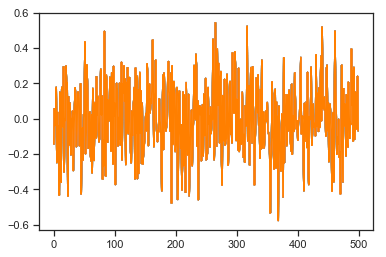

In [88]:
for i in np.arange(0,20):
    plt.plot(anomalies_run[i,:])

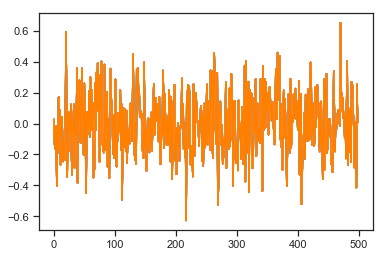

In [95]:
for i in np.arange(0,20):
    plt.plot(anomalies_run[i,:])

# BURNIN 

In [96]:
trait_strategy = 'value' #Options: 'value', 'variance', 'percentile'
value = 27 #For value strategy
scaling_frac = 0.5 #For variance strategy
percentile = 50 #For percentile strategy

In [97]:
# Alter the baseline percent cover on the source reef in order to set the amount of coral cover to send to 
# restoration reefs. The amount in the third column doesn't matter since macroalgae don't experience recruitment
# from other sites
# This does NOT matter for the burnin
#source_cover = np.ones((num_restore,nsp)) #this sets every source reef at 1, 
#can set with another array to change values

source_cover = np.array([1e-49,1e-49])
#source_cover = np.array([1e-49,1e-49])

#Start (and keep) restoration source reefs at the baseline amount with specified trait value
trait_restore_val = value
spp_state_restore[-num_restore:,:] = source_cover
trait_state_restore[-num_restore,:] = np.repeat(value,nsp)

# This is where you tell the model when to use the restoration matrix; we can write something more sophisticated to
# generate this later on. For example, something that takes in a "frequency" instead of having to manually input years
restoration_years = []

#trait_strategy = 'value'

#burnin 
time_steps=burnin
timemod = 0 #to offset algae mortality index
parameters_dict = {'nsp': nsp, 
                    'size': size, 
                    'time_steps': burnin, 
                    'species_type': species_type, 
                    'V': V, 
                    'D0': D_no_restore, 
                    'D1': D_restore,
                    'beta': beta,
                    'r_max': r_max,
                    'alphas': alphas,
                    'mortality_model': mortality_model,
                    'mpa_status': mpa_status,
                    'w': w,
                    'm_const': m_const,
                    'maxtemp': maxtemp,
                    'annual_temp_change': annual_temp_change,
                    'timemod': timemod,
                    'restoration_years': restoration_years,
                    'source_cover': source_cover,
                    'trait_strategy': trait_strategy,
                    'value': value,
                    'scaling_frac': scaling_frac,
                    'percentile': percentile,
                    'num_restore':num_restore,
                    'restore_array':restore_array
                    }

In [98]:
#Calls NEW coral_restore_fun2() that sets trait value using the method with various restoration trait strategies
time0 = time.time()
N0, Z0, SST_burnin = coral_restore_fun2(parameters_dict,spp_state_restore,trait_state_restore,
                                                   SST0_restore,anomalies_burn_restore,
                                                   algaemort_restore,temp_change="constant",
                                                   burnin=True)


time1 = time.time()
total = (time1-time0)/60
print total

BURNIN
5.22911800146


In [99]:
V

array([[0.1, 0.1]])

## Plotting by patch type

In [85]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

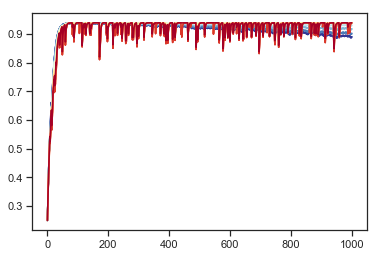

In [86]:
cmap = discrete_cmap(10, base_cmap="RdYlBu")
color_idx = np.linspace(0, 1, 10)
species = 0

for i, idx in zip(np.arange(0,10), color_idx):
    plt.plot(N0[i,species,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    plt.plot(N0[i,species,:], color=cmap(idx))

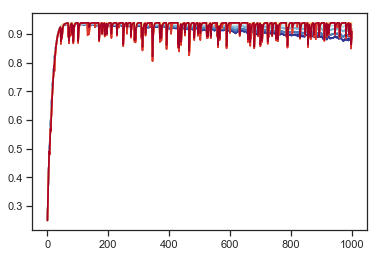

In [93]:
cmap = discrete_cmap(10, base_cmap="RdYlBu")
color_idx = np.linspace(0, 1, 10)
species = 0

for i, idx in zip(np.arange(0,10), color_idx):
    plt.plot(N0[i,species,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    plt.plot(N0[i,species,:], color=cmap(idx))

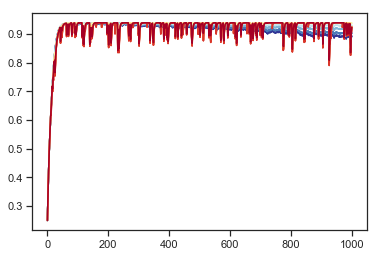

In [100]:
cmap = discrete_cmap(10, base_cmap="RdYlBu")
color_idx = np.linspace(0, 1, 10)
species = 0

for i, idx in zip(np.arange(0,10), color_idx):
    plt.plot(N0[i,species,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    plt.plot(N0[i,species,:], color=cmap(idx))

In [ ]:
cmap = discrete_cmap(10, base_cmap="RdYlBu")
color_idx = np.linspace(0, 1, 10)
species = 0

for i, idx in zip(np.arange(0,10), color_idx):
    plt.plot(N0[i,species,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    plt.plot(N0[i,species,:], color=cmap(idx))

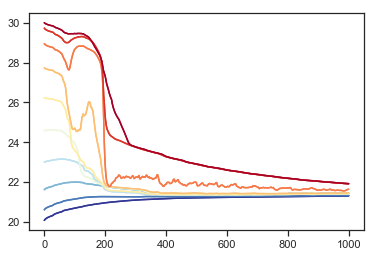

In [116]:
cmap = discrete_cmap(10, base_cmap="RdYlBu")
color_idx = np.linspace(0, 1, 10)
species = 0

for i, idx in zip(np.arange(0,10), color_idx):
    plt.plot(Z0[i,species,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    plt.plot(Z0[i,species,:], color=cmap(idx))

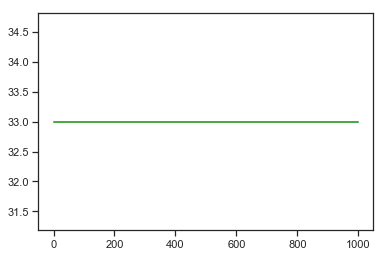

In [102]:
species = 0
for i in np.arange(20,24):
    plt.plot(Z0[i,species,:])

# Convert npy to CSV
## Save a time series for each species separately

In [135]:
burnin_N_sp1 = N0[:,0,:]
burnin_N_sp2 = N0[:,1,:]
burnin_N_sp3 = N0[:,2,:]

burnin_Z_sp1 = Z0[:,0,:]
burnin_Z_sp2 = Z0[:,1,:]
burnin_Z_sp3 = Z0[:,2,:]

#! Save each species as a separate file: species percent cover
np.savetxt("burnin_N_sp1.csv", burnin_N_sp1, delimiter=',')
np.savetxt("burnin_N_sp2.csv", burnin_N_sp2, delimiter=',')
np.savetxt("burnin_N_sp3.csv", burnin_N_sp3, delimiter=',')

#! Save each species as a separate file: species trait value
np.savetxt("burnin_Z_sp1.csv", burnin_Z_sp1, delimiter=',')
np.savetxt("burnin_Z_sp2.csv", burnin_Z_sp2, delimiter=',')
np.savetxt("burnin_Z_sp3.csv", burnin_Z_sp3, delimiter=',')

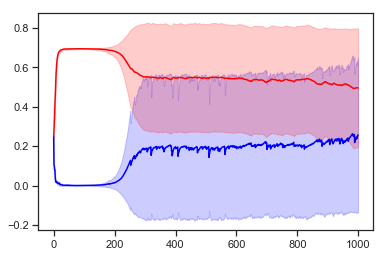

In [285]:
#! BURNIN PLOTS: Species percent cover
# Plot species 1 trajectory (averaged across all reefs - except for restoration reef)
species1_mean = N0[:-num_restore,0,:].mean(axis=0)
species1_std = N0[:-num_restore,0,:].std(axis=0)
plt.plot(species1_mean ,color='b')
plt.fill_between(np.arange(0,burnin),species1_mean-species1_std,species1_mean+species1_std, alpha=0.2, 
                 edgecolor='b', facecolor='b')

# Plot species 2 trajectory (averaged across all reefs)
species2_mean = N0[:-num_restore,1,:].mean(axis=0)
species2_std = N0[:-num_restore,1,:].std(axis=0)
plt.plot(species2_mean ,color='r')
plt.fill_between(np.arange(0,burnin),species2_mean-species2_std,species2_mean+species2_std, alpha=0.2, 
                 edgecolor='r', facecolor='r')

# Plot species 3 trajectory (averaged across all reefs)
#species3_mean = N0[:-1,2,:].mean(axis=0)
#species3_std = N0[:-1,2,:].std(axis=0)
#plt.plot(species3_mean ,color='g')
#plt.fill_between(np.arange(0,burnin),species3_mean-species3_std,species3_mean+species3_std, alpha=0.2, 
#                 edgecolor='g', facecolor='g')

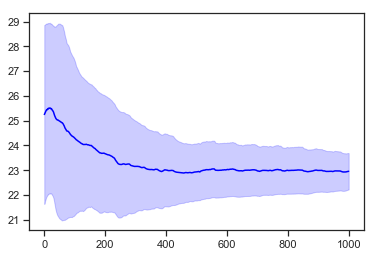

In [286]:
#! BURNIN PLOTS: Trait values
# Plot species 1 trajectory (averaged across all reefs)
species1_mean = Z0[:-num_restore,0,:].mean(axis=0)
species1_std = Z0[:-num_restore,0,:].std(axis=0)
plt.plot(species1_mean ,color='b')
plt.fill_between(np.arange(0,burnin),species1_mean-species1_std,species1_mean+species1_std, alpha=0.2, 
                 edgecolor='b', facecolor='b')

# Plot species 2 trajectory (averaged across all reefs)
#species2_mean = Z0[:-1,1,:].mean(axis=0)
#species2_std = Z0[:-1,1,:].std(axis=0)
#plt.plot(species2_mean ,color='r')
#plt.fill_between(np.arange(0,burnin),species2_mean-species2_std,species2_mean+species2_std, alpha=0.2, 
#                 edgecolor='r', facecolor='r')

# Plot species 3 trajectory (averaged across all reefs)
#species3_mean = Z0[:-1,2,:].mean(axis=0)
#species3_std = Z0[:-1,2,:].std(axis=0)
#plt.plot(species3_mean ,color='g')
#plt.fill_between(np.arange(0,burnin),species3_mean-species3_std,species3_mean+species3_std, alpha=0.2, 
#                edgecolor='g', facecolor='g')

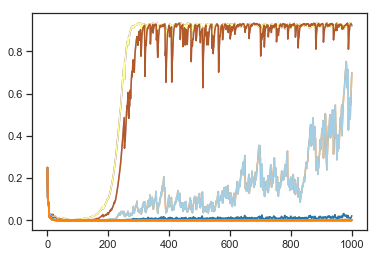

In [287]:
#! Plot species 1 trajectories
species = 0
for i in np.arange(0,20):
    plt.plot(N0[i,species,:])

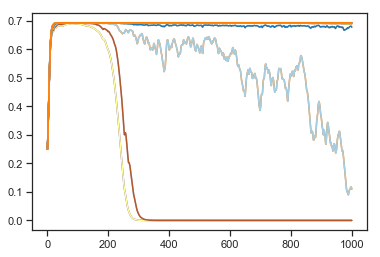

In [288]:
#! Plot species 2 trajectories
species = 1
for i in np.arange(0,20):
    plt.plot(N0[i,species,:])

## RUNTIME: restoration happening every year

In [ ]:
trait_strategy = 'value' #Options: 'value', 'variance', 'percentile'
value = 27 #For value strategy
scaling_frac = 0.5 #For variance strategy
percentile = 50 #For percentile strategy

In [ ]:
# Alter the baseline percent cover on the source reef in order to set the amount of coral cover to send to 
# restoration reefs. The amount in the third column doesn't matter since macroalgae don't experience recruitment
# from other sites
source_cover = np.array([1.0,1e-49])
# Note: the code does NOT like having a zero value in one of these; use 1e-6 to approximate zero

#runtime parameters: all restoration years
mpa_status = set_MPA_fun(SST0,spp_state,species_type,size,amount=0.2,strategy='none')
time_steps = runtime

# This is where you tell the model when to use the restoration matrix; we can write something more sophisticated to
# generate this later on. For example, something that takes in a "frequency" instead of having to manually input years

#restoration_years = [1,5,20]
restoration_years = list(range(runtime)) #restoration occurs during all years in runtime
#restoration_years = []

timemod = burnin #to offset algae mortality index

parameters_dict = {'nsp': nsp, 
                    'size': size, 
                    'time_steps': runtime, 
                    'species_type': species_type, 
                    'V': V, 
                    'D0': D_no_restore, 
                    'D1': D_restore,
                    'beta': beta,
                    'r_max': r_max,
                    'alphas': alphas,
                    'mortality_model': mortality_model,
                    'mpa_status': mpa_status,
                    'w': w,
                    'm_const': m_const,
                    'maxtemp': maxtemp,
                    'annual_temp_change': annual_temp_change,
                    'timemod': timemod,
                    'restoration_years': restoration_years,
                    'source_cover': source_cover,
                    'trait_strategy': trait_strategy,
                    'value': value,
                    'scaling_frac': scaling_frac,
                    'percentile': percentile,
                    'num_restore':num_restore,
                    'restore_array':restore_array
                    }

In [82]:
value

27

In [ ]:
#Calls NEW coral_restore_fun2()
time0 = time.time()
N1, Z1, SST_runtime = coral_restore_fun2(parameters_dict,N0[:,:,-1],Z0[:,:,-1],
                                                   SST_burnin[:,-1],anomalies_run_restore,
                                                   algaemort_restore,temp_change="sigmoid",
                                                   burnin=False)
time1 = time.time()
total = (time1-time0)/60
print total

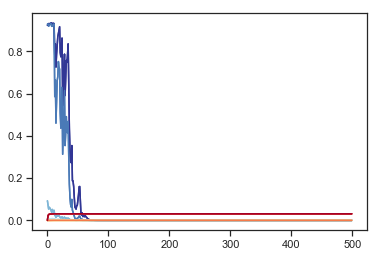

In [77]:
N1_33 = N1[:]
Z1_33 = Z1[:]

cmap = discrete_cmap(10, base_cmap="RdYlBu")
color_idx = np.linspace(0, 1, 10)
coral = 0

for i, idx in zip(np.arange(0,10), color_idx):
    plt.plot(N1_33[i,coral,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    plt.plot(N1_33[i,coral,:], color=cmap(idx))

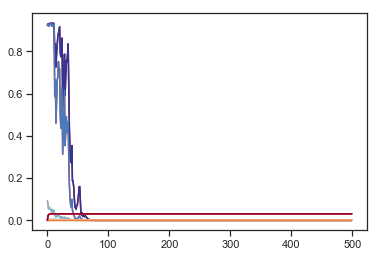

In [81]:
for i, idx in zip(np.arange(0,10), color_idx):
    plt.plot(N1_33[i,coral,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    plt.plot(N1_33[i,coral,:], color=cmap(idx))

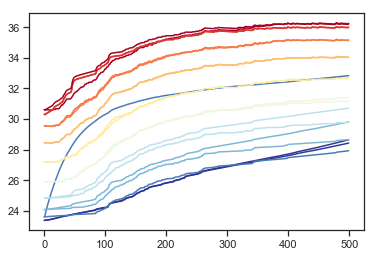

In [120]:
cmap = discrete_cmap(10, base_cmap="RdYlBu")
color_idx = np.linspace(0, 1, 10)
coral = 0

for i, idx in zip(np.arange(0,10), color_idx):
    plt.plot(Z1_36[i,coral,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    plt.plot(Z1_36[i,coral,:], color=cmap(idx))

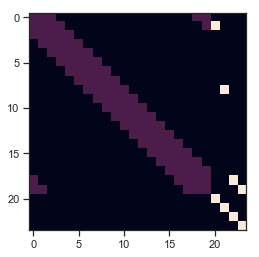

In [121]:
plt.imshow(D_restore)

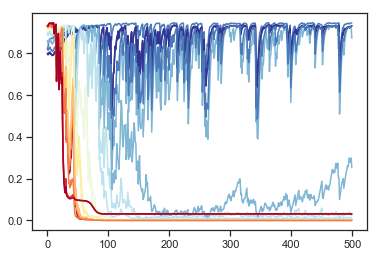

In [102]:
cmap = discrete_cmap(10, base_cmap="RdYlBu")
color_idx = np.linspace(0, 1, 10)
coral = 0

for i, idx in zip(np.arange(0,10), color_idx):
    plt.plot(N1[i,coral,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    plt.plot(N1[i,coral,:], color=cmap(idx))

array([[0.1, 0.1]])

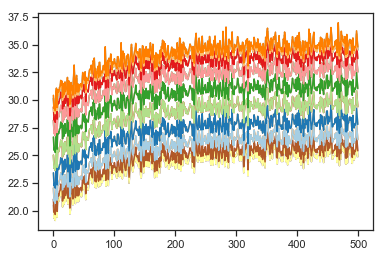

In [262]:
for i in np.arange(0,20):
    plt.plot(SST_runtime[i,:])

# Convert npy to CSV
## Save a time series for each species separately

In [137]:
runtime_N_sp1 = N1[:,0,:]
runtime_N_sp2 = N1[:,1,:]
runtime_N_sp3 = N1[:,2,:]

runtime_Z_sp1 = Z1[:,0,:]
runtime_Z_sp2 = Z1[:,1,:]
runtime_Z_sp3 = Z1[:,2,:]

#! Save each species as a separate file: species percent cover
np.savetxt("runtime_N_sp1.csv", runtime_N_sp1, delimiter=',')
np.savetxt("runtime_N_sp2.csv", runtime_N_sp2, delimiter=',')
np.savetxt("runtime_N_sp3.csv", runtime_N_sp3, delimiter=',')

#! Save each species as a separate file: species trait value
np.savetxt("runtime_Z_sp1.csv", runtime_Z_sp1, delimiter=',')
np.savetxt("runtime_Z_sp2.csv", runtime_Z_sp2, delimiter=',')
np.savetxt("runtime_Z_sp3.csv", runtime_Z_sp3, delimiter=',')

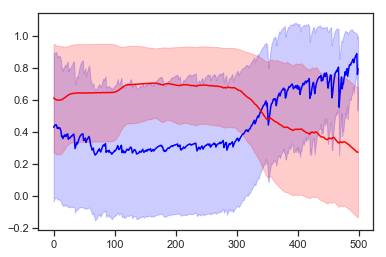

In [319]:
#! RUNTIME PLOTS: species percent cover
# Plot species 1 trajectory (averaged across all reefs)
species1_mean = N1[:-num_restore,0,:].mean(axis=0)
species1_std = N1[:-num_restore,0,:].std(axis=0)
plt.plot(species1_mean ,color='b')
plt.fill_between(np.arange(0,runtime),species1_mean-species1_std,species1_mean+species1_std, alpha=0.2, 
                 edgecolor='b', facecolor='b')

# Plot species 2 trajectory (averaged across all reefs)
species2_mean = N1[:-num_restore,1,:].mean(axis=0)
species2_std = N1[:-num_restore,1,:].std(axis=0)
plt.plot(species2_mean ,color='r')
plt.fill_between(np.arange(0,runtime),species2_mean-species2_std,species2_mean+species2_std, alpha=0.2, 
                 edgecolor='r', facecolor='r')

# Plot species 3 trajectory (averaged across all reefs)
#species3_mean = N1[:-1,2,:].mean(axis=0)
#species3_std = N1[:-1,2,:].std(axis=0)
#plt.plot(species3_mean ,color='g')
#plt.fill_between(np.arange(0,runtime),species3_mean-species3_std,species3_mean+species3_std, alpha=0.2, 
#                 edgecolor='g', facecolor='g')

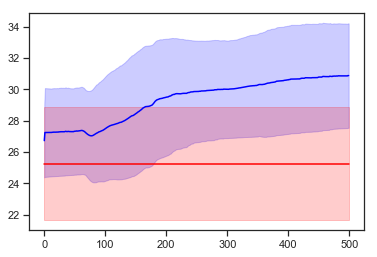

In [266]:
#! BURNIN PLOTS: Trait values
# Plot species 1 trajectory (averaged across all reefs)
species1_mean = Z1[:-num_restore,0,:].mean(axis=0)
species1_std = Z1[:-num_restore,0,:].std(axis=0)
plt.plot(species1_mean ,color='b')
plt.fill_between(np.arange(0,runtime),species1_mean-species1_std,species1_mean+species1_std, alpha=0.2, 
                 edgecolor='b', facecolor='b')

# Plot species 2 trajectory (averaged across all reefs)
species2_mean = Z1[:-num_restore,1,:].mean(axis=0)
species2_std = Z1[:-num_restore,1,:].std(axis=0)
plt.plot(species2_mean ,color='r')
plt.fill_between(np.arange(0,runtime),species2_mean-species2_std,species2_mean+species2_std, alpha=0.2, 
                 edgecolor='r', facecolor='r')

# Plot species 3 trajectory (averaged across all reefs)
#species3_mean = Z1[:-1,2,:].mean(axis=0)
#species3_std = Z1[:-1,2,:].std(axis=0)
#plt.plot(species3_mean ,color='g')
#plt.fill_between(np.arange(0,runtime),species3_mean-species3_std,species3_mean+species3_std, alpha=0.2, 
#                 edgecolor='g', facecolor='g')

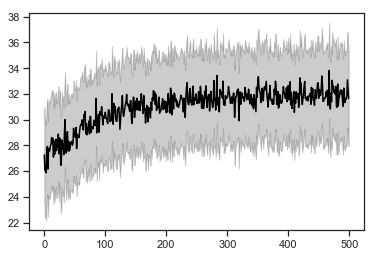

In [267]:
SST = SST_runtime
SST_mean = SST.mean(axis=0)
SST_std = SST.std(axis=0)
plt.plot(SST_mean ,color='k')
plt.fill_between(np.arange(0,runtime),SST_mean-SST_std,SST_mean+SST_std, 
                 alpha=0.2, edgecolor='k', facecolor='k')

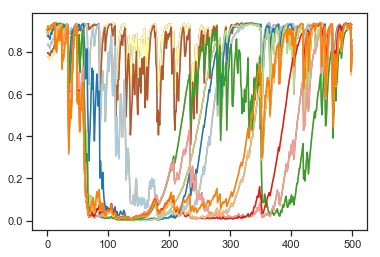

In [268]:
#! Plot species 1 trajectories
species = 0
for i in np.arange(0,20):
    plt.plot(N1[i,species,:])

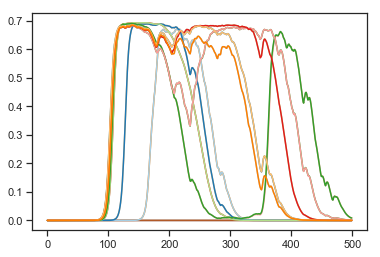

In [269]:
#! Plot species 2 trajectories
species = 1
for i in np.arange(0,20):
    plt.plot(N1[i,species,:])

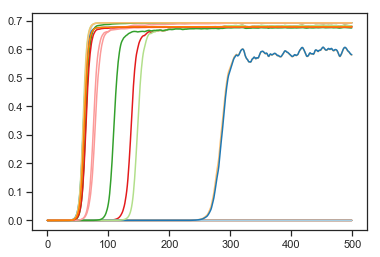

In [534]:
#! Plot species 3 trajectories
species = 2
for i in np.arange(0,20):
    plt.plot(N1[i,species,:])

# RUNTIME: no restoration

In [446]:
#runtime parameters
mpa_status = set_MPA_fun(SST0,spp_state,species_type,size,amount=0.2,strategy='none')
time_steps = runtime
# This is where you tell the model when to use the restoration matrix; we can write something more sophisticated to
# generate this later on. For example, something that takes in a "frequency" instead of having to manually input years
#restoration_years = [1,5,20]
#restoration_years = list(range(runtime))
restoration_years = []

timemod = burnin #to offset algae mortality index
parameters_dict = {'nsp': nsp, 
                    'size': size, 
                    'time_steps': runtime, 
                    'species_type': species_type, 
                    'V': V, 
                    'D0': D_no_restore, 
                    'D1': D_restore,
                    'beta': beta,
                    'r_max': r_max,
                    'alphas': alphas,
                    'mortality_model': mortality_model,
                    'mpa_status': mpa_status,
                    'w': w,
                    'm_const': m_const,
                    'maxtemp': maxtemp,
                    'annual_temp_change': annual_temp_change,
                    'timemod':timemod,
                    'restoration_years':restoration_years,
                    'source_cover':source_cover
                    }



time0 = time.time()

N2, Z2, SST_runtime2 = coral_restore_fun(parameters_dict,N0[:,:,-1],Z0[:,:,-1],
                                        SST_burnin[:,-1],anomalies_burn_restore,algaemort_restore,
                                        temp_change="sigmoid", trait_restore=trait_restore_val,
                                        burnin=False)

time1 = time.time()
total = (time1-time0)/60
print total

RUNTIME
0.641909134388


# Convert npy to CSV
## Save a time series for each species separately

In [ ]:
runtime_N_sp1 = N2[:,0,:]
runtime_N_sp2 = N2[:,1,:]
runtime_N_sp3 = N2[:,2,:]

runtime_Z_sp1 = Z2[:,0,:]
runtime_Z_sp2 = Z2[:,1,:]
runtime_Z_sp3 = Z2[:,2,:]

#! Save each species as a separate file: species percent cover
np.savetxt("runtime_N_sp1.csv", runtime_N_sp1, delimiter=',')
np.savetxt("runtime_N_sp2.csv", runtime_N_sp2, delimiter=',')
np.savetxt("runtime_N_sp3.csv", runtime_N_sp3, delimiter=',')

#! Save each species as a separate file: species trait value
np.savetxt("runtime_Z_sp1.csv", runtime_Z_sp1, delimiter=',')
np.savetxt("runtime_Z_sp2.csv", runtime_Z_sp2, delimiter=',')
np.savetxt("runtime_Z_sp3.csv", runtime_Z_sp3, delimiter=',')

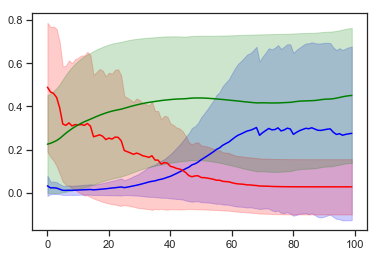

In [447]:
#! RUNTIME PLOTS
# Plot species 1 trajectory (averaged across all reefs)
species1_mean = N2[:,0,:].mean(axis=0)
species1_std = N2[:,0,:].std(axis=0)
plt.plot(species1_mean ,color='b')
plt.fill_between(np.arange(0,runtime),species1_mean-species1_std,species1_mean+species1_std, alpha=0.2, 
                 edgecolor='b', facecolor='b')

# Plot species 2 trajectory (averaged across all reefs)
species2_mean = N2[:,1,:].mean(axis=0)
species2_std = N2[:,1,:].std(axis=0)
plt.plot(species2_mean ,color='r')
plt.fill_between(np.arange(0,runtime),species2_mean-species2_std,species2_mean+species2_std, alpha=0.2, 
                 edgecolor='r', facecolor='r')

# Plot species 3 trajectory (averaged across all reefs)
species3_mean = N2[:,2,:].mean(axis=0)
species3_std = N2[:,2,:].std(axis=0)
plt.plot(species3_mean ,color='g')
plt.fill_between(np.arange(0,runtime),species3_mean-species3_std,species3_mean+species3_std, alpha=0.2, 
                 edgecolor='g', facecolor='g')

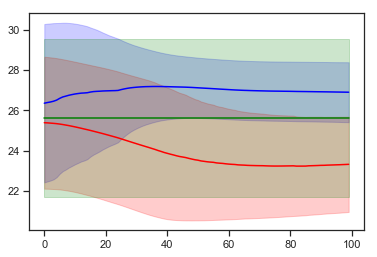

In [448]:
#! BURNIN PLOTS: Trait values
# Plot species 1 trajectory (averaged across all reefs)
species1_mean = Z2[:,0,:].mean(axis=0)
species1_std = Z2[:,0,:].std(axis=0)
plt.plot(species1_mean ,color='b')
plt.fill_between(np.arange(0,runtime),species1_mean-species1_std,species1_mean+species1_std, alpha=0.2, 
                 edgecolor='b', facecolor='b')

# Plot species 2 trajectory (averaged across all reefs)
species2_mean = Z2[:,1,:].mean(axis=0)
species2_std = Z2[:,1,:].std(axis=0)
plt.plot(species2_mean ,color='r')
plt.fill_between(np.arange(0,runtime),species2_mean-species2_std,species2_mean+species2_std, alpha=0.2, 
                 edgecolor='r', facecolor='r')

# Plot species 3 trajectory (averaged across all reefs)
species3_mean = Z2[:,2,:].mean(axis=0)
species3_std = Z2[:,2,:].std(axis=0)
plt.plot(species3_mean ,color='g')
plt.fill_between(np.arange(0,runtime),species3_mean-species3_std,species3_mean+species3_std, alpha=0.2, 
                 edgecolor='g', facecolor='g')

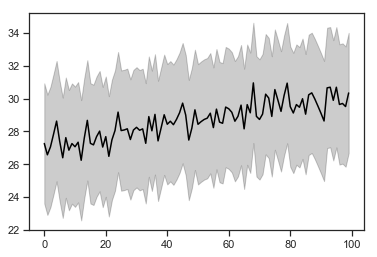

In [449]:
SST = SST_runtime2
SST_mean = SST.mean(axis=0)
SST_std = SST.std(axis=0)
plt.plot(SST_mean ,color='k')
plt.fill_between(np.arange(0,runtime),SST_mean-SST_std,SST_mean+SST_std, 
                 alpha=0.2, edgecolor='k', facecolor='k')

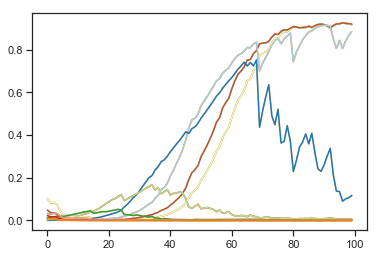

In [450]:
#! Plot species 1 trajectories
species = 0
for i in np.arange(0,20):
    plt.plot(N2[i,species,:])

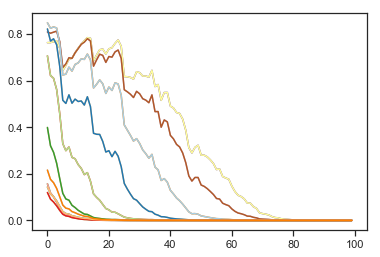

In [451]:
#! Plot species 2 trajectories
species = 1
for i in np.arange(0,20):
    plt.plot(N2[i,species,:])

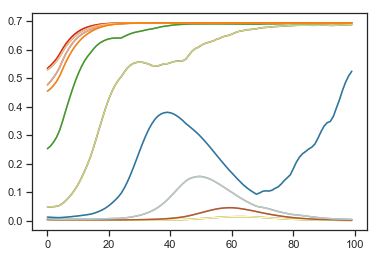

In [452]:
#! Plot species 3 trajectories
species = 2
for i in np.arange(0,20):
    plt.plot(N2[i,species,:])

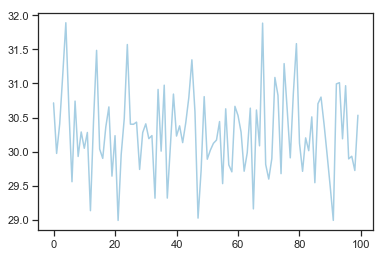

In [453]:
plt.plot(SST_burnin[1,:])

# Load numpy files and plot them

In [ ]:
# Change the address to wherever you have the N and Z files saved
#Burn-in output
N0 = np.load("/Volumes/Samsung/Adaptation/Regular/single1/N0.npy")
Z0 = np.load("/Volumes/Samsung/Adaptation/Regular/single1/Z0.npy")
#Runtime output
N1 = np.load("/Volumes/Samsung/Adaptation/Regular/single1/N1.npy")
Z1 = np.load("/Volumes/Samsung/Adaptation/Regular/single1/Z1.npy")

In [ ]:
#! RUNTIME PLOTS
# Plot species 1 trajectory (averaged across all reefs)
species1_mean = N1[:,0,:].mean(axis=0)
species1_std = N1[:,0,:].std(axis=0)
plt.plot(species1_mean ,color='b')
plt.fill_between(np.arange(0,runtime),species1_mean-species1_std,species1_mean+species1_std, alpha=0.2, 
                 edgecolor='b', facecolor='b')

# Plot species 2 trajectory (averaged across all reefs)
species2_mean = N1[:,1,:].mean(axis=0)
species2_std = N1[:,1,:].std(axis=0)
plt.plot(species2_mean ,color='r')
plt.fill_between(np.arange(0,runtime),species2_mean-species2_std,species2_mean+species2_std, alpha=0.2, 
                 edgecolor='r', facecolor='r')

In [ ]:
# You can then convert them to csv files, as in the previous section
runtime_N_sp1 = N1[:,0,:]
runtime_N_sp2 = N1[:,1,:]

runtime_Z_sp1 = Z1[:,0,:]
runtime_Z_sp2 = Z1[:,1,:]

#! Save each species as a separate file: species percent cover
np.savetxt("runtime_N_sp1.csv", runtime_N_sp1, delimiter=',')
np.savetxt("runtime_N_sp2.csv", runtime_N_sp2, delimiter=',')

#! Save each species as a separate file: species trait value
np.savetxt("runtime_Z_sp1.csv", runtime_Z_sp1, delimiter=',')
np.savetxt("runtime_Z_sp2.csv", runtime_Z_sp2, delimiter=',')